#### Update Previous Neighbor Data
Test utility to measure the performance of several implementations of  `test/individuals/update_previous_neighbor_data` in multiple languages.

In [1]:
import os

languages_to_test = []

for dir in os.listdir("."):
    if not dir.endswith(".ipynb"):
        # skip cpp tests in windows for now
        if os.name == "nt" and dir == "cpp":
            continue
          
        languages_to_test.append(dir)

In [2]:
import subprocess

def build_test(build_command):
    subprocess.run(build_command)


def get_test_data(test_command):
    bytes = subprocess.check_output(test_command)
    bytes_string = bytes.decode("utf-8") \
                         .replace("\r", "") \
                         .replace("\n", "") \
                         .replace(" ", "")

    memory, runtime = bytes_string.split(",")   
    memory = int(memory)
    runtime = float(runtime)     
                         
    return (memory, runtime)

In [3]:
language_commands = {
  "go": { 
    "test": "go run go\\{version}\\main.go"
  },
  "cpp": {
    "build": "g++ -std=c++11 cpp\\{version}\\main.cpp -o cpp\\{version}\\main",
    "test": "cpp\\{version}\\main"
  },
  "python": {
    "test": "python python\\{version}\\main.py"
  },
  "java": { # TODO: fix java build command errors
    "build": "javac java\\{version}\\Main.java java\\Individual.java",
    "test": "java java\\{version}\\Main"
  },
  "julia": {
    "test": "julia julia\\{version}\\main.jl"
  },
  "ts": { # TODO: fix ts build command errors
    "build": "npm --prefix ts run build-{version}",
    "test": "npm --prefix ts test"
  },
  "rust": { # TODO: fix rust build command errors
    "build": "rustc rust\\{version}\\main.rs",
    "test": "rust\\{version}\\main"
  }
}

In [4]:
import datetime
import csv
import os


ITERATIONS = 50
tested_languages_data = []

for language_to_test in ["python", "julia", "go"]:
    versions_to_test = []
    for dir in os.listdir(language_to_test):
        if dir in ["optimized", "unoptimized"]:
            versions_to_test.append(dir)

    for version_to_test in versions_to_test:
        language_command = language_commands[language_to_test]

        if len(language_command) == 2:
            build_test(language_command["build"].format(version=version_to_test))

        memory_list = []
        runtime_list = []
        
        for _ in range(ITERATIONS):
            memory, runtime = get_test_data(language_command["test"].format(version=version_to_test))
            memory_list.append(memory)
            runtime_list.append(runtime)

        data_directory = os.path.join(language_to_test, version_to_test, "data")
        os.makedirs(data_directory, exist_ok=True)

        timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        csv_file_path = os.path.join(data_directory, f"{timestamp}.csv")
        tested_languages_data.append({
          "language": language_to_test,
          "version": version_to_test,
          "csv_file_path": csv_file_path,
        })

        with open(csv_file_path, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Iteration", "Memory", "Runtime"])

            for i in range(len(memory_list)):
                writer.writerow([i, memory_list[i], runtime_list[i]])

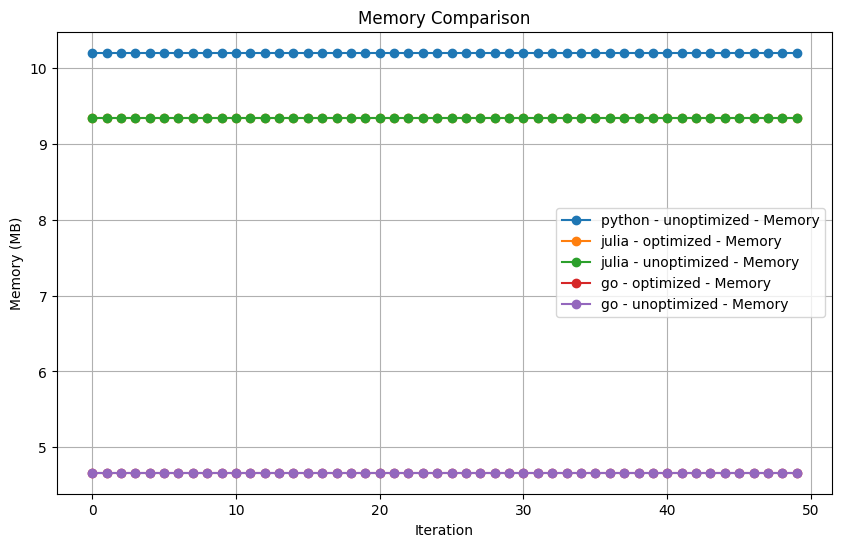

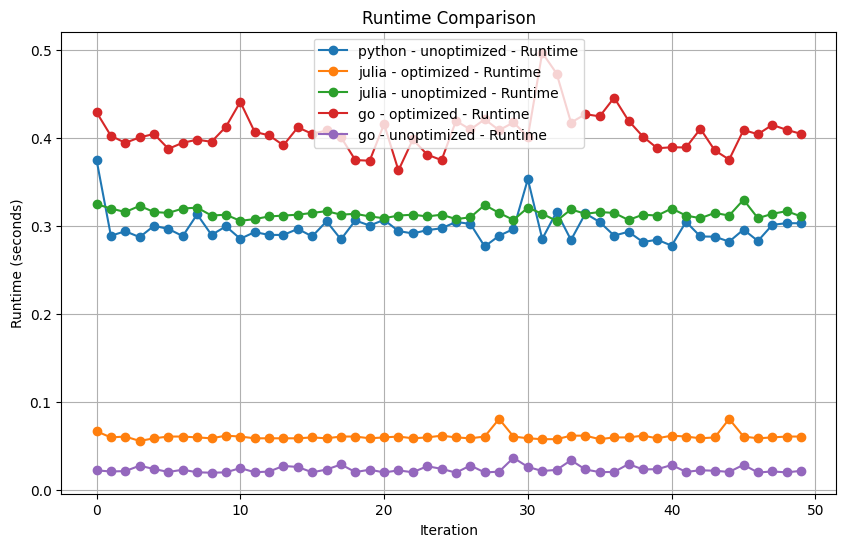

In [5]:
import csv
import matplotlib.pyplot as plt


memory_data = []
runtime_data = []

for tested_language_data in tested_languages_data:
    csv_file_path = tested_language_data["csv_file_path"]
    test_name = f"{tested_language_data['language']} - {tested_language_data['version']}"

    test_data = []
    with open(csv_file_path, mode="r") as file:
        reader = csv.DictReader(file)
        for row in reader:
            test_data.append(row)

    iterations = [int(data["Iteration"]) for data in test_data]
    memory_values = [float(data["Memory"]) / 1024 / 1024 for data in test_data]
    runtime_values = [float(data["Runtime"]) for data in test_data]

    memory_data.append((test_name, iterations, memory_values))
    runtime_data.append((test_name, iterations, runtime_values))

plt.figure(figsize=(10, 6))
for test_name, iterations, memory_values in memory_data:
    plt.plot(iterations, memory_values, marker="o", label=f"{test_name} - Memory")
plt.xlabel("Iteration")
plt.ylabel("Memory (MB)")
plt.title("Memory Comparison")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for test_name, iterations, runtime_values in runtime_data:
    plt.plot(iterations, runtime_values, marker="o", label=f"{test_name} - Runtime")
plt.xlabel("Iteration")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparison")
plt.legend()
plt.grid(True)
plt.show()
